# Big Data Analytics Homework 04

*Complete this assignment in Google Colab. Prior to submitting a copy of this notebook (.ipynb format), run every cell and ensure you have corrected all runtime errors. Be sure to fill in your Name and SUID in the following cell. As always, you must do your own work. This means you may not use answers to the following questions generated by any other person or a generative AI tool such as ChatGPT. You may, however, discuss this assignment with others in a general way and seek help when you need it, but, again, you must do your own work.*

Name:Hendi Kushta

SUID:7522109662

### Setup

In [1]:
! pip install pyspark -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

spark = SparkSession\
    .builder\
    .appName('Homework 04')\
    .getOrCreate()

This assignment uses a data set containing information about data science programs at universities worldwide.

The dataset contains many columns that we can use to understand how these data science programs differ from one another.

In [3]:
# download the data scince programs data set
%%bash
if [[ ! -f colleges-data-science-programs.csv ]]; then
 wget https://syr-bda.s3.us-east-2.amazonaws.com/colleges-data-science-programs.csv -q
fi

### Q1

Read `colleges-data-science-programs.csv` into a Spark data frame named `raw_ds_programs_text`.

In [4]:
# your code here

file_path = "colleges-data-science-programs.csv"
raw_ds_programs_text = spark.read.csv(file_path, header=True, inferSchema=True)

In [5]:
# do not modify
print('rows: ', raw_ds_programs_text.count(),
      ', cols:', len(raw_ds_programs_text.columns))

raw_ds_programs_text\
  .show(5)

rows:  222 , cols: 28
+---+--------------------+--------------------+--------------------+-------+-------+-----+------+--------+--------------------+-------------------+-------------------+----------------+------------+-------+----------+------------+-----+----+-------------+----------------+--------+---------+--------------------+--------+---------+---------+------+
| id|                name|                 url|             program| degree|country|state|online|oncampus|          department|         created_at|         updated_at|university_count|program_size|courses|admit_reqs|year_founded|notes|cost|visualization|machine learning|business|databases|programminglanguages|capstone|mapreduce|part-time|ethics|
+---+--------------------+--------------------+--------------------+-------+-------+-----+------+--------+--------------------+-------------------+-------------------+----------------+------------+-------+----------+------------+-----+----+-------------+----------------+--------+--

### Q2

Starting with `raw_ds_programs_text`, create a new data frame named `ds_programs_text` which simply adds a column named `text` to the original data frame.

The `text` column will be a concatenation of the following columns, separated by a space: `program`, `degree`, and `department`. You eill find the appropriate function in `pyspark.sql.functions`

An example of the `ds_programs_text_df` should give you:

```python
ds_programs_text.orderBy('id').first().text
```

```console
'Data Science Masters Mathematics and Statistics'
```

In [6]:
# your code here
from pyspark.sql.functions import col, concat_ws

# Create ds_programs_text DataFrame
ds_programs_text = raw_ds_programs_text.withColumn(
    'text',
    concat_ws(' ', col('program'), col('degree'), col('department'))
)

In [7]:
# do not modify
ds_programs_text.select('text')\
  .show(5, truncate = False)

+------------------------------------------------------------------+
|text                                                              |
+------------------------------------------------------------------+
|Data Science Masters Mathematics and Statistics                   |
|Analytics Masters Business and Information Systems                |
|Data Science Masters Computer Science                             |
|Business Intelligence & Analytics Masters Business                |
|Advanced Computer Science(Data Analytics) Masters Computer Science|
+------------------------------------------------------------------+
only showing top 5 rows



### Q3

Create a pipeline named `pipe_features` that creates a new dataframe `ds_features`. The `pipe_features` pipeline should add a column, `features` to `ds_programs_text` that contains the `tfidf` of the `text` column.

Make sure to create your pipeline using methodology similar to what was demonstrated in class.  

In [8]:
# your code here
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
import requests

# Tokenizer: Split the text into words
tokenizer = Tokenizer(inputCol="text", outputCol="words")

# StopWordsRemover: Remove common words (stop words) from the text
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words')\
  .text\
  .split()
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(stop_words)

# HashingTF: Convert words to numerical features using HashingTF
hashing_tf = HashingTF(inputCol="filtered", outputCol="tf")

# IDF: Compute the Inverse Document Frequency
idf = IDF(inputCol="tf", outputCol="features")

# Create a pipeline
pipe_features = Pipeline(stages=[tokenizer, stopwords_remover, hashing_tf, idf])

# Fit the pipeline to the original DataFrame
pipe_model = pipe_features.fit(ds_programs_text)
ds_features = pipe_model.transform(ds_programs_text)

In [9]:
# do not modify
ds_features.select('features')\
  .show(5,
        truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                 |
+-----------------------------------------------------------------------------------------------------------------------------------------+
|(262144,[2574,49708,160735,178129,190787],[0.2538801769623398,2.462732792293678,0.6709733230656233,3.615412302232064,1.2962979072868075])|
|(262144,[2574,22732,25513,38574,116782],[0.2538801769623398,0.8222042927895469,3.009276498661748,2.411439497906128,1.0377239189930973])  |
|(262144,[2574,160735,190787],[0.2538801769623398,0.6709733230656233,2.592595814573615])                                                  |
|(262144,[2574,22732,51144,81060,116782],[0.2538801769623398,0.8222042927895469,3.3277302297802827,2.316129318101803,2.0754478379861947]) |
|(262144,[2574,16702

### Q4

Create a pipeline model called `pipe_pca` that computes the first two principle components of the `features` column created by `pipe_features`, and creates a new column named `scores`.

Use `pipe_pca` to create a data frame, `ds_features_1` with the columns `id`, `name`, `url`, and `scores`.

Note: Prior to computing PCA scores, you will want to scale the TF-IDF outputs. Refer to lecture notes regarding the appropriate parameters to use during this step.

In [10]:
# your code here

from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler

# StandardScaler for scaling the TF-IDF outputs
scaler = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='scaled_tfidf')

# PCA for computing the first two principal components
pca = PCA(k=2, inputCol='scaled_tfidf', outputCol='scores')

# Create the pipeline model
pipe_pca = Pipeline(stages=[scaler, pca])

# Fit the pipeline model to ds_features
pipe_pca_model = pipe_pca.fit(ds_features)

# Transform ds_features to obtain the PCA scores
ds_features_pca = pipe_pca_model.transform(ds_features)

# Extract the necessary columns from the transformed dataframe
ds_features_1 = ds_features_pca.select('id', 'name', 'url', 'scores')

In [11]:
# do not modify
ds_features_1\
  .select('scores')\
  .show(5,
        truncate = False)

+---------------------------------------------+
|scores                                       |
+---------------------------------------------+
|[-0.26874415918747674,-0.4344302178077288]   |
|[-0.32864817065676133,2.104257913226881]     |
|[-0.0028206069881388544,-0.41690483289881825]|
|[-0.8485791207087733,-0.001255405689566546]  |
|[-0.19402822664110295,-0.4111957312746048]   |
+---------------------------------------------+
only showing top 5 rows



### Q5

In this question you will write code that makes recommendations for programs closest to a program of interest.  

Create a function named `get_nearest_programs` that returns the 3 closest programs to a program of interest.

The `get_nearest_programs` function should take 1 argument: `program_of_interest`. Write the function so that it returns the 3 programs (as defined by the `name` column) closest to the program argument as defined by Euclidian (L2) distance. Do not return the program of interest as one of the names.

Your function should **not** consider **Bachelors** programs.

In [12]:
# your code here

from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
from pyspark.sql import DataFrame

def euclidean_distance(vector1, vector2):
    return float(Vectors.squared_distance(vector1, vector2))**0.5


  # This function returns the 3 closest programs to a given program by calculating
  # the distance between the PCA scores of the selected program to the rest of programs

def get_nearest_programs(program_of_interest: str, programs_df: DataFrame = ds_features_1) -> list:
    # Extract PCA scores for the program of interest
    program_scores = (
        programs_df
        .filter(col('name') == program_of_interest)
        .select('scores')
        .collect()[0]['scores']
    )

    # Exclude Bachelors programs and calculate Euclidean distance
    nearest_programs = (
        programs_df
        .filter((col('degree') != 'Bachelors') & (col('name') != program_of_interest))
        .select('name', 'scores')
        .rdd
        .map(lambda row: (row['name'], euclidean_distance(row['scores'], program_scores)))
        .toDF(['name', 'distance'])
        .orderBy('distance')
        .limit(3)
        .select('name')
        .collect()
    )

    result = [row['name'] for row in nearest_programs]
    return result

In [13]:
# do not modify
get_nearest_programs('Syracuse University')

['Universit�_t Konstanz',
 'Robert Gordon University',
 'Sheffield Hallam University']

### Q6

Create two Pandas dataframes `pc1` and `pc2` with the columns `word` and `absolute_loading` that contain the top 5 absolute values (descending order) of loadings.

In [15]:
# your code here

import pandas as pd

# Assuming ds_features_1 is your dataframe with PCA scores
pc_loadings = pipe_pca_model.stages[1].pc.toArray()

# Create a Pandas dataframe for the first principal component (pc1)
pc1_loadings = pd.DataFrame({
    'word': ds_features_1.columns[3],  # Assuming the features start from column 4
    'load_pc1': pc_loadings[:, 0]
})

# Sort by absolute loading in descending order and take the top 5
pc1_loadings['absolute_loading'] = abs(pc1_loadings['load_pc1'])
pc1_loadings = pc1_loadings.sort_values(by='absolute_loading', ascending=False).head(5)
pc1 = pc1_loadings[['word', 'absolute_loading']]

# Create a Pandas dataframe for the second principal component (pc2)
pc2_loadings = pd.DataFrame({
    'word': ds_features_1.columns[3],  # Assuming the features start from column 4
    'load_pc2': pc_loadings[:, 1]
})

# Sort by absolute loading in descending order and take the top 5
pc2_loadings['absolute_loading'] = abs(pc2_loadings['load_pc2'])
pc2_loadings = pc2_loadings.sort_values(by='absolute_loading', ascending=False).head(5)
pc2 = pc2_loadings[['word', 'absolute_loading']]

In [16]:
# do not modify
display(pc1.head())
display(pc2.head())

,word,absolute_loading
165443,scores,0.580729
77920,scores,0.499646
92648,scores,0.308371
239379,scores,0.308371
61031,scores,0.283370


,word,absolute_loading
38574,scores,0.604629
103341,scores,0.336743
25513,scores,0.262752
50617,scores,0.240699
51913,scores,0.200191


### Q7

Create a new pipeline called `pipe_pca_1` where you fit the maximum possible number of principal components for this dataset.

Create a scree plot and a plot of cumulative variance explained (exactly 2 plots).

Answer the following:

1. How many principal components were able to create (the maximum number)?

2. Based on either the scree or cumulative variance explained plot, how many principal components would you use if you were building a supervised machine learning model, and why?

In [17]:
# your code for new pipeline here
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import PCA

# Create a new pipeline model with the maximum number of principal components
max_pca = PCA(k=20, inputCol='scaled_tfidf', outputCol='scores_max')
pipe_pca_1 = Pipeline(stages=[scaler, max_pca])
pipe_pca_model_1 = pipe_pca_1.fit(ds_features)
ds_features_max_pca = pipe_pca_model_1.transform(ds_features)

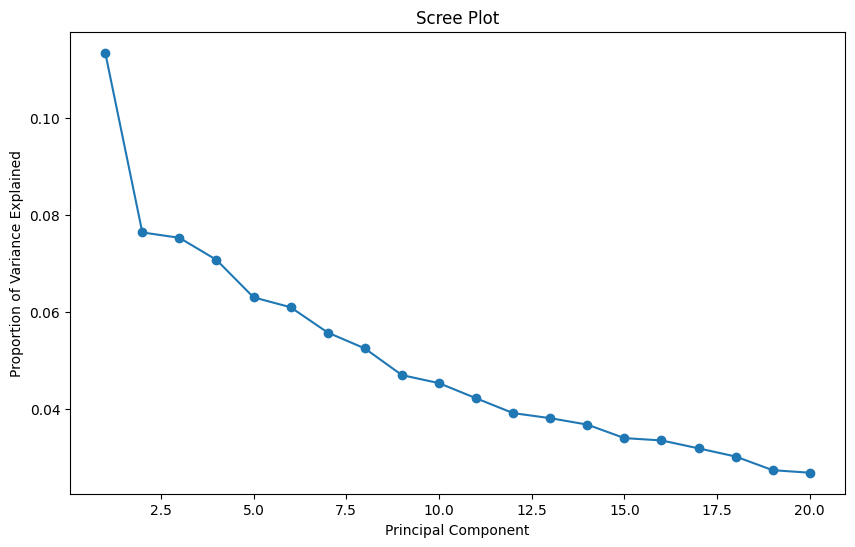

In [18]:
# your code for scree plot here
# Scree Plot
num_components = len(pipe_pca_model_1.stages[-1].explainedVariance)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, num_components + 1), pipe_pca_model_1.stages[-1].explainedVariance, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

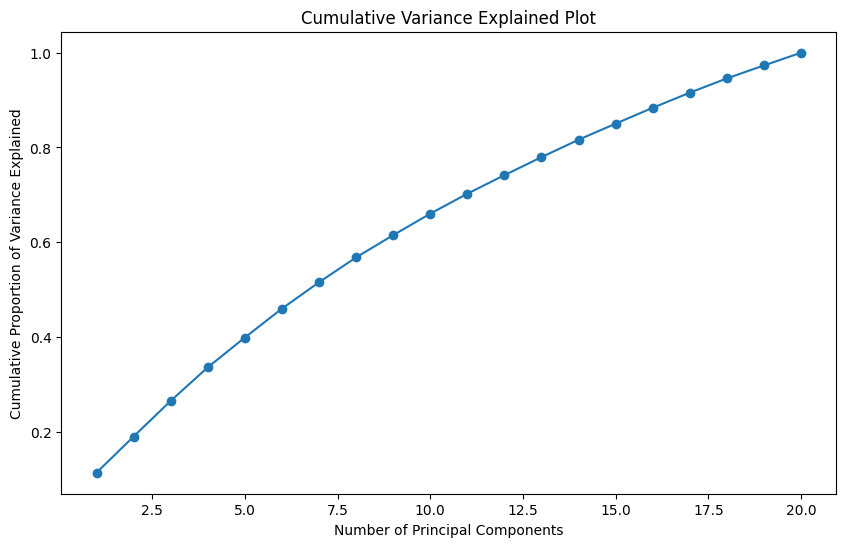

In [19]:
# your code for cumulative variance explained plot here
cumulative_variance = np.cumsum(pipe_pca_model_1.stages[-1].explainedVariance)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, num_components + 1), cumulative_variance, marker='o')
plt.title('Cumulative Variance Explained Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.show()

There were created 20 principal components.
Based on Scree plot the number of principal components I would choose is 2 since there we can see a huge break, indicating that it might be a good number of components.
Observing the variance explained plot, it looks like it increases constantly, so 20 components would be good, since after that I think the line will be in a more constant way. It also explains a high percentage of the varuance, so we can get more information in the data.

### Q8

Starting with `pipe_pca_1` from the previous question, transform the pipeline and save the resulting dataframe to a variable named `pca_fun`.  

Extract the output from the standard scaler column from the first row of `pca_fun` and store in a variable named `row1_centered`.

Manually compute 5 PCA scores by projecting `row1_centered` onto the first 5 loading vectors which were computed in your PCA object. Save the 5 projected pca scores in a varialbe called `proj_scores`.

Extract the first 5 PCA scores from the first row of the pca_fun scores column and save them in a variable named `pca_fun_scores`.

In [20]:
# your answer here
# Transform the pipeline and save the resulting dataframe
pca_fun = pipe_pca_model_1.transform(ds_features)

# Extract the output from the standard scaler column from the first row of pca_fun
row1_centered = pca_fun.select('scaled_tfidf').first()['scaled_tfidf']

# Manually computing 5 PCA scores by projecting row1_centered onto the first 5 loading vectors
loading_vectors = pipe_pca_model_1.stages[1].pc.toArray()[:, :5]
proj_scores = np.dot(row1_centered.toArray(), loading_vectors)

# Extract the first 5 PCA scores from the first row of the pca_fun scores column
pca_fun_scores = pca_fun.select('scores_max').first()['scores_max'][:5]

In [21]:
# do not modify
print(proj_scores)
print(pca_fun_scores)

[ 0.26874416 -0.43443022 -1.99990463 -0.45846524  0.14171739]
[ 0.26874416 -0.43443022 -1.99990463 -0.45846524  0.14171739]


### Q9

Perform an **inverse transform** on the `proj_scores` variable and store the result in a variable named `inverse`.

The grading cell below prints `inverse` and the original `row1_centered` data such that they are right next to each other.

If `inverse` is different than `row1_centered`, explain why. How you could modify the forward and reverse transformation process such that the resulting `inverse` data almost exactly matches `row1_centered`.

In [30]:
# your code here
# Perform an inverse transform on the proj_scores variable
inverse = np.dot(proj_scores, loading_vectors.T) + pipe_pca_model_1.stages[0].mean

# Adjusted comparison with a tolerance
tolerance = 1e-5
matching_result = np.allclose(row1_centered, inverse, atol=tolerance)

# Check if the arrays almost exactly match within the specified tolerance
print("\nArrays almost exactly match:", matching_result)


Arrays almost exactly match: False


In [31]:
# do not modify
print(row1_centered[0:5])
print(inverse[0:5])

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


### Q10

Implement your modification so that `row1_centered` and `inverse` match almost exactly.

In [27]:
# your code here
# Perform an inverse transform on the proj_scores variable
inverse = np.dot(proj_scores, loading_vectors.T) + pipe_pca_model_1.stages[0].mean


In [28]:
# do not modify
print(row1_centered[0:5])
print(inverse[0:5])

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
